In [1]:
# .py file auto-generated from the .ipynb file
import duckdb
import traceback


def is_in_notebook():
    # https://stackoverflow.com/a/67622408
    rstk = traceback.extract_stack(limit=1)[0]
    return rstk[0].startswith("<ipython")

In [2]:
if is_in_notebook():
    ! jupyter nbconvert --to script --no-prompt process_peaks.ipynb

[NbConvertApp] Converting notebook process_peaks.ipynb to script
[NbConvertApp] Writing 12698 bytes to process_peaks.py


In [3]:
# This notebook compiles itself to a python script.
# the meant usage is to run it with a subset of the data
# and then commit the file for use on cloud training.

if is_in_notebook():
    PATH_PREFIX = "../prospect_data"
    con = duckdb.connect("prospect_dev.ddb")
else:
    import logging

    logging.info("Running in cloud environment!!!!")
    con = duckdb.connect("prospect_prod.ddb")
    PATH_PREFIX = "gs://jspp_prospect_mirror"

METADATA_FILES = f"{PATH_PREFIX}/*meta_data.parquet"
ANNOTATION_FILES = f"{PATH_PREFIX}/*annotation.parquet"

In [4]:
print(con.sql(f"SELECT * FROM parquet_scan('{METADATA_FILES}') LIMIT 5").to_df())

                                      raw_file  scan_number  \
0  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        34341   
1  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        39787   
2  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        23850   
3  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1         5398   
4  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        26459   

                                   modified_sequence  precursor_charge  \
0                                        DNYDQLVRIAK                 2   
1                                        MDLESQISDMR                 2   
2                                         QLQQIERQLK                 2   
3  PC[UNIMOD:4]C[UNIMOD:4]C[UNIMOD:4]QTTC[UNIMOD:...                 2   
4                                        LNTEVTTWRTK                 2   

   precursor_intensity         mz  precursor_mz fragmentation mass_analyzer  \
0          141925100.0  667.85678    667.854794           HCD          FTMS   
1           637602

In [5]:
print(con.sql(f"SELECT * FROM parquet_scan('{ANNOTATION_FILES}') LIMIT 5").to_df())

  ion_type  no  charge  experimental_mass  theoretical_mass  intensity  \
0        y   3       1          302.22772        302.134661       0.02   
1        y   6       2          302.22772        302.140278       0.02   
2        b   3       1          302.22772        302.149919       0.02   
3        y   5       2          302.22772        302.686864       0.02   
4        y   3       1          320.32074        320.145226       0.05   

  neutral_loss  fragment_score    peptide_sequence  scan_number  \
0    C2H5N-H2O              65  AFTFDDEDDELSQLKESK        34380   
1  C4H11N-C4H8              39  AFTFDDEDDELSQLKESK        34380   
2          H2O              95  AFTFDDEDDELSQLKESK        34380   
3                           99  AFTFDDEDDELSQLKESK        34380   
4        C2H5N              70  AFTFDDEDDELSQLKESK        34380   

                                      raw_file  
0  01829a_GA3-TUM_third_pool_3_01_01-DDA-1h-R1  
1  01829a_GA3-TUM_third_pool_3_01_01-DDA-1h-R1  
2  01

In [6]:
query = f"""
CREATE OR REPLACE TABLE rt_qc AS
SELECT
    modified_sequence,
    MEDIAN(retention_time) as retention_time_m,
    MEDIAN(indexed_retention_time) as irt_m,
    QUANTILE_CONT(retention_time, 0.25) as retention_time_q25,
    QUANTILE_CONT(retention_time, 0.75) as retention_time_q75,
    QUANTILE_CONT(indexed_retention_time, 0.25) as irt_q25,
    QUANTILE_CONT(indexed_retention_time, 0.75) as irt_q75,
    COUNT(*) as n
FROM
(
    SELECT modified_sequence, andromeda_score, retention_time, indexed_retention_time,
    FROM
    (
        SELECT 
            modified_sequence,
            andromeda_score,
            retention_time,
            indexed_retention_time,
            row_number() OVER (
                PARTITION BY modified_sequence, fragmentation, mass_analyzer
                ORDER BY andromeda_score DESC
            ) AS scan_rank
        FROM "{METADATA_FILES}"
    ) FILER WHERE scan_rank <= 20            -- take top 20 scans
)
GROUP BY modified_sequence
HAVING n >= 5 AND irt_q75 - irt_q25 < 10    -- require at least 5 scans and irt range < 10
"""

con.sql(query)

In [7]:
con.sql("SELECT * FROM rt_qc")

┌──────────────────────┬────────────────────┬────────────────────┬───┬────────────────────┬───────┐
│  modified_sequence   │  retention_time_m  │       irt_m        │ … │      irt_q75       │   n   │
│       varchar        │       double       │       double       │   │       double       │ int64 │
├──────────────────────┼────────────────────┼────────────────────┼───┼────────────────────┼───────┤
│ AAAHGQWELQRVHAK      │             20.646 │ 17.541545097044274 │ … │ 17.851162082614437 │    39 │
│ AAEADGPLK            │             18.423 │  8.703935823514659 │ … │ 12.084482326397591 │    15 │
│ AARVIIEK             │             19.753 │ 11.381455814659317 │ … │ 11.383985027062577 │     5 │
│ AAVQGDHPQLQLSLAIGL…  │            46.5985 │  82.93348986779642 │ … │  83.80160568082918 │    60 │
│ AC[UNIMOD:4]LPGHKQ…  │ 11.682500000000001 │ -5.097432254135797 │ … │ -4.923345605235214 │    60 │
│ AEEQPM[UNIMOD:35]T…  │               47.7 │  87.06583456954321 │ … │   87.4187938001944 │     5 │


In [8]:
con.sql(
    f"""
    CREATE OR REPLACE TABLE filtered_meta AS
    SELECT
        raw_file,
        scan_number,
        modified_sequence,
        precursor_charge,
        precursor_intensity,
        mz,
        precursor_mz,
        fragmentation,
        mass_analyzer,
        retention_time,
        indexed_retention_time,
        orig_collision_energy,
        peptide_length,
        aligned_collision_energy,
        retention_time_m,
        irt_m
    FROM (
        SELECT *,
        row_number() OVER (
                        PARTITION BY
                            "{METADATA_FILES}".modified_sequence,
                            "{METADATA_FILES}".precursor_charge,
                            "{METADATA_FILES}".fragmentation,
                            "{METADATA_FILES}".mass_analyzer,
                            "{METADATA_FILES}".orig_collision_energy
                        ORDER BY ABS("{METADATA_FILES}".retention_time - rt_qc.retention_time_m) ASC
                    ) AS rt_diff_rank
        FROM "{METADATA_FILES}" 
        JOIN rt_qc ON ("{METADATA_FILES}".modified_sequence = rt_qc.modified_sequence)
        WHERE retention_time <= retention_time_q75 AND retention_time >= retention_time_q25
    )
    WHERE rt_diff_rank <= 10 AND peptide_length < 35
    """
)

In [9]:
con.sql("SELECT * FROM filtered_meta")

┌──────────────────────┬─────────────┬────────────────────┬───┬────────────────────┬───────────────────┐
│       raw_file       │ scan_number │ modified_sequence  │ … │  retention_time_m  │       irt_m       │
│       varchar        │    int64    │      varchar       │   │       double       │      double       │
├──────────────────────┼─────────────┼────────────────────┼───┼────────────────────┼───────────────────┤
│ 01812a_GA3-TUM_thi…  │       19102 │ AAAHGQWELQR        │ … │              24.14 │ 26.30147432638536 │
│ 01812a_GA3-TUM_thi…  │       19171 │ AAAHGQWELQR        │ … │              24.14 │ 26.30147432638536 │
│ 01812a_GA3-TUM_thi…  │       19088 │ AAAHGQWELQR        │ … │              24.14 │ 26.30147432638536 │
│ 01812a_GA3-TUM_thi…  │       19153 │ AAAHGQWELQR        │ … │              24.14 │ 26.30147432638536 │
│ 01812a_GA3-TUM_thi…  │       19023 │ AAAHGQWELQR        │ … │              24.14 │ 26.30147432638536 │
│ 01812a_GA3-TUM_thi…  │       18970 │ AAAHGQWELQR     

In [10]:
con.sql(
    f"""
        SELECT
            raw_file,
            scan_number,
            peptide_sequence,
            ion_type,
            no,
            charge,
            intensity,
            experimental_mass,
            theoretical_mass,
            fragment_score,
        FROM "{ANNOTATION_FILES}"
        WHERE neutral_loss = '' AND scan_number = 44454 AND ion_type = 'y' AND no = 3 AND charge = 2 AND peptide_sequence LIKE 'SHYVAQTGILWLLM%'
        GROUP BY raw_file, scan_number, peptide_sequence, ion_type, no, charge, intensity, experimental_mass, theoretical_mass, fragment_score
    """
).to_df()


# Note how multiple peaks can match a single fragment if there is ambiguity in the annotation
# This seems to happen in very rare cases and it cannot be solved by the fragment score.

# Just to get it over with I will use the max intensity one.

# I am using here a cherry-picked example that popped up during my qc of the data
# after the aggregation.

,raw_file,scan_number,peptide_sequence,ion_type,no,charge,intensity,experimental_mass,theoretical_mass,fragment_score
0,01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-1...,44454,SHYVAQTGILWLLM[UNIMOD:35]NNC[UNIMOD:4]FLNLSPRK,y,3,2,0.04,200.17453,200.636978,99
1,01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-1...,44454,SHYVAQTGILWLLM[UNIMOD:35]NNC[UNIMOD:4]FLNLSPRK,y,3,2,0.07,201.11533,200.636978,99


In [11]:
con.sql(
    f"""
    CREATE OR REPLACE TABLE filtered_annotations AS
    SELECT
        raw_file,
        scan_number,
        peptide_sequence,
        precursor_charge,
        ion_type,
        no,
        charge,
        intensity,
        theoretical_mass as theoretical_fragment_mz,
        precursor_mz,
        fragmentation,
        mass_analyzer,
        retention_time,
        indexed_retention_time,
        orig_collision_energy,
        aligned_collision_energy,
    FROM (
        SELECT 
            filtered_meta.raw_file as raw_file,
            filtered_meta.scan_number as scan_number,
            peptide_sequence,
            precursor_charge,
            ion_type,
            no,
            charge,
            intensity,
            mz,
            theoretical_mass,
            precursor_mz,
            fragmentation,
            mass_analyzer,
            retention_time,
            indexed_retention_time,
            orig_collision_energy,
            aligned_collision_energy
        FROM
        (
            -- This section filters out neutral losses and keeps only the highest
            -- intensity fragment for each fragment type/position/charge combination
            SELECT * FROM
            (
                SELECT
                    *,
                    row_number() OVER (
                                    PARTITION BY
                                        peptide_sequence,
                                        scan_number,
                                        raw_file,
                                        ion_type,
                                        charge,
                                        no
                                    ORDER BY intensity DESC
                                ) AS fragment_rank
                FROM "{ANNOTATION_FILES}"
                WHERE neutral_loss = ''
            )
            WHERE fragment_rank = 1
        ) AS ranked_annots
        JOIN filtered_meta
        ON ranked_annots.peptide_sequence = filtered_meta.modified_sequence
        AND ranked_annots.scan_number = filtered_meta.scan_number
        AND ranked_annots.raw_file = filtered_meta.raw_file
    )
    GROUP BY ALL
    ORDER BY peptide_sequence, raw_file, scan_number
    """
)

con.sql("SELECT * FROM filtered_annotations LIMIT 10").to_df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,raw_file,scan_number,peptide_sequence,precursor_charge,ion_type,no,charge,intensity,theoretical_fragment_mz,precursor_mz,fragmentation,mass_analyzer,retention_time,indexed_retention_time,orig_collision_energy,aligned_collision_energy
0,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,y,4,2,0.02,273.155732,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
1,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,b,6,1,0.25,536.257572,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
2,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,y,1,1,0.07,175.118952,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
3,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,y,8,2,0.11,527.264865,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
4,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,b,6,2,0.04,268.632424,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
5,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,b,5,1,0.08,408.198994,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
6,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,b,10,2,0.13,546.764698,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
7,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,b,7,2,0.38,361.672081,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
8,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,b,7,1,0.17,722.336885,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0
9,01812a_GA3-TUM_third_pool_1_01_01-2xIT_2xHCD-1...,18970,AAAHGQWELQR,3,y,2,1,0.33,303.177530,422.882597,CID,ITMS,24.052,26.204881,35.0,35.0


In [12]:
con.sql(
    """
    CREATE OR REPLACE TABLE averaged_annotations AS
    SELECT
        LIST(raw_file),
        LIST(scan_number),
        filtered_annotations.peptide_sequence,
        precursor_charge,
        filtered_annotations.ion_type,
        filtered_annotations.no
            AS fragment_no,
        filtered_annotations.charge
            AS fragment_charge,
        SUM(filtered_annotations.intensity)/MAX(num_peptide_spec)
            AS fragment_intensity,
        MAX(filtered_annotations.intensity)
            AS max_fragment_intensity_prior_to_averaging,
        filtered_annotations.theoretical_fragment_mz,
        MEAN(filtered_annotations.precursor_mz)
            AS precursor_mz,
        filtered_annotations.fragmentation,
        filtered_annotations.mass_analyzer,
        MEAN(filtered_annotations.retention_time)
            AS retention_time,
        MEAN(indexed_retention_time)
            AS indexed_retention_time,
        filtered_annotations.orig_collision_energy,
        MEAN(aligned_collision_energy)
            AS aligned_collision_energy,
        num_peptide_spec,                                -- this is the number of spectra that were averaged
        COUNT(*) 
            AS num_averaged,
        COUNT(*) / MAX(num_peptide_spec) 
            AS pct_averaged -- the percentage of spectra that contained this fragment
    FROM (
        SELECT 
            peptide_sequence,
            mass_analyzer,
            fragmentation,
            orig_collision_energy,
            COUNT(DISTINCT scan_number || '::' || raw_file) AS num_peptide_spec
        FROM (
            SELECT DISTINCT
                raw_file,
                scan_number,
                peptide_sequence,
                mass_analyzer,
                fragmentation,
                orig_collision_energy
            FROM
                filtered_annotations
        ) AS inner_tmp
        GROUP BY peptide_sequence, mass_analyzer, fragmentation, orig_collision_energy
    ) AS middle_tmp
    JOIN filtered_annotations
    ON middle_tmp.peptide_sequence = filtered_annotations.peptide_sequence
    AND middle_tmp.mass_analyzer = filtered_annotations.mass_analyzer
    AND middle_tmp.fragmentation = filtered_annotations.fragmentation
    AND middle_tmp.orig_collision_energy = filtered_annotations.orig_collision_energy
    GROUP BY ALL
    ORDER BY filtered_annotations.peptide_sequence, filtered_annotations.no
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [13]:
print(
    con.sql(
        """
    SELECT * from averaged_annotations ORDER BY pct_averaged DESC LIMIT 10
    """
    )
)

con.sql(
    """
SELECT * from averaged_annotations ORDER BY pct_averaged ASC LIMIT 10
"""
).to_df()

┌──────────────────────┬──────────────────────┬──────────────────────┬───┬──────────────┬──────────────┐
│    list(raw_file)    │  list(scan_number)   │   peptide_sequence   │ … │ num_averaged │ pct_averaged │
│      varchar[]       │       int64[]        │       varchar        │   │    int64     │    double    │
├──────────────────────┼──────────────────────┼──────────────────────┼───┼──────────────┼──────────────┤
│ [01812a_GD3-TUM_th…  │ [17031, 16977, 169…  │ YPSSQLGEMSLEEHSQC[…  │ … │            8 │          1.0 │
│ [01812a_GD3-TUM_th…  │ [16978, 16962, 168…  │ YPSSQLGEMSLEEHSQC[…  │ … │            7 │          1.0 │
│ [01812a_GD3-TUM_th…  │ [16978, 16962, 168…  │ YPSSQLGEMSLEEHSQC[…  │ … │            7 │          1.0 │
│ [01812a_GD3-TUM_th…  │ [17031, 16977, 169…  │ YPSSQLGEMSLEEHSQC[…  │ … │            8 │          1.0 │
│ [01812a_GD3-TUM_th…  │ [17031, 16977, 169…  │ YPSSQLGEMSLEEHSQC[…  │ … │            8 │          1.0 │
│ [01812a_GD3-TUM_th…  │ [17031, 16977, 169…  │ YPSSQLG

,list(raw_file),list(scan_number),peptide_sequence,precursor_charge,ion_type,fragment_no,fragment_charge,fragment_intensity,max_fragment_intensity_prior_to_averaging,theoretical_fragment_mz,precursor_mz,fragmentation,mass_analyzer,retention_time,indexed_retention_time,orig_collision_energy,aligned_collision_energy,num_peptide_spec,num_averaged,pct_averaged
0,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27492],PELLSGHIPPGHIPKPIVMPDYVAK,3,y,3,1,0.0028,0.07,317.218332,902.499695,HCD,FTMS,42.296,68.658569,25.0,27.273282,25,1,0.04
1,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27494],PELLSGHIPPGHIPKPIVMPDYVAK,3,b,4,1,0.0036,0.09,453.270761,902.499695,HCD,FTMS,42.298,68.663437,35.0,37.273282,25,1,0.04
2,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27493],PELLSGHIPPGHIPKPIVMPDYVAK,3,b,5,1,0.0032,0.08,540.302789,902.499695,HCD,FTMS,42.297,68.661003,30.0,32.273282,25,1,0.04
3,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27492],PELLSGHIPPGHIPKPIVMPDYVAK,3,b,6,1,0.0020,0.05,597.324253,902.499695,HCD,FTMS,42.296,68.658569,25.0,27.273282,25,1,0.04
4,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27444],PELLSGHIPPGHIPKPIVMPDYVAK,4,y,7,2,0.0008,0.02,412.204565,677.126597,HCD,FTMS,42.255,68.558771,30.0,32.273282,25,1,0.04
5,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27492],PELLSGHIPPGHIPKPIVMPDYVAK,3,b,9,1,0.0024,0.06,944.519993,902.499695,HCD,FTMS,42.296,68.658569,25.0,27.273282,25,1,0.04
6,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27493],PELLSGHIPPGHIPKPIVMPDYVAK,3,b,9,1,0.0028,0.07,944.519993,902.499695,HCD,FTMS,42.297,68.661003,30.0,32.273282,25,1,0.04
7,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27494],PELLSGHIPPGHIPKPIVMPDYVAK,3,b,9,1,0.0028,0.07,944.519993,902.499695,HCD,FTMS,42.298,68.663437,35.0,37.273282,25,1,0.04
8,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27785],PELLSGHIPPGHIPKPIVMPDYVAK,4,b,10,2,0.0012,0.03,521.290017,677.377270,HCD,FTMS,42.573,69.332814,30.0,32.273282,25,1,0.04
9,[01812a_GD3-TUM_third_pool_6_01_01-3xHCD-1h-R1],[27876],PELLSGHIPPGHIPKPIVMPDYVAK,4,b,10,1,0.0028,0.07,1041.572757,677.377370,HCD,FTMS,42.659,69.542146,35.0,37.273282,25,1,0.04


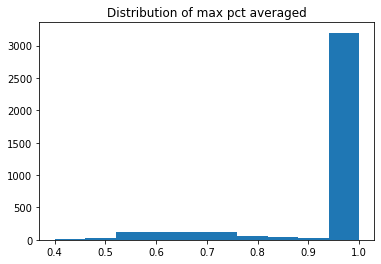

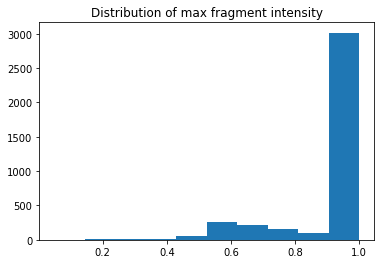

In [14]:
if is_in_notebook():
    from matplotlib import pyplot as plt

    df = con.sql(
        "SELECT peptide_sequence, MAX(pct_averaged) AS max_pct_avg, MAX(fragment_intensity) as max_intensity FROM averaged_annotations GROUP BY peptide_sequence"
    ).to_df()
    plt.hist(df["max_pct_avg"])
    plt.title("Distribution of max pct averaged")
    plt.show()

    plt.hist(df["max_intensity"])
    plt.title("Distribution of max fragment intensity")
    plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

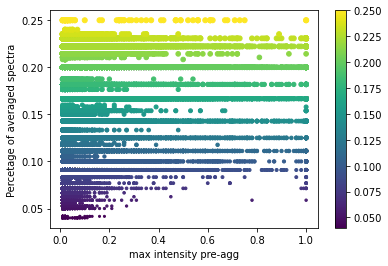

In [15]:
if is_in_notebook():
    from matplotlib import pyplot as plt

    df = con.sql(
        """
        SELECT * from averaged_annotations ORDER BY pct_averaged ASC LIMIT 100000
        """
    ).to_df()
    df
    plt.scatter(
        y=df["pct_averaged"],
        x=df["max_fragment_intensity_prior_to_averaging"],
        c=df["num_averaged"] / df["num_peptide_spec"],
        s=(df["num_averaged"] / df["num_peptide_spec"]) * 100,
    )
    plt.ylabel("Percetage of averaged spectra")
    plt.xlabel("max intensity pre-agg")
    plt.colorbar()
    # Save the plot to a file
    plt.savefig("peak_aggregation.png")
    plt.show()

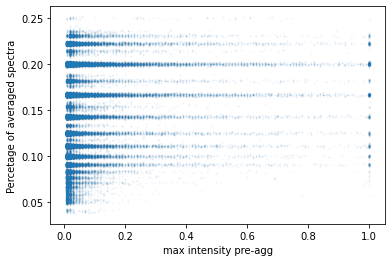

In [16]:
if is_in_notebook():
    import numpy as np

    plt.scatter(
        y=df["pct_averaged"] + np.random.normal(0, 0.001, len(df)),
        x=df["max_fragment_intensity_prior_to_averaging"]
        + np.random.normal(0, 0.001, len(df)),
        s=1,
        alpha=0.05,
    )
    plt.ylabel("Percetage of averaged spectra")
    plt.xlabel("max intensity pre-agg")

In [17]:
con.sql(
    """
    CREATE OR REPLACE TABLE nested_annotations AS
    SELECT
        peptide_sequence,
        -- TODO: Add stripped peptide here
        precursor_charge,
        LIST (ion_type),
        LIST (fragment_no), -- TODO consider filter for this 
        LIST (fragment_charge),
        LIST (fragment_intensity),
        LIST (theoretical_fragment_mz),
        fragmentation,
        mass_analyzer,
        MEAN(retention_time) as retention_time,
        MEAN(indexed_retention_time) as indexed_retention_time,
        orig_collision_energy,
        MEAN(aligned_collision_energy) as aligned_collision_energy,
    FROM averaged_annotations
    WHERE 
        -- pretty liberal filter, I am assuming that peaks that were not averaged 
        -- are low abundance ... BUT who knows ...
        pct_averaged > 0.1 
    GROUP BY peptide_sequence, precursor_charge, fragmentation, mass_analyzer, orig_collision_energy
    """
)

In [18]:
con.sql("SELECT * FROM nested_annotations LIMIT 5").to_df()

,peptide_sequence,precursor_charge,list(ion_type),list(fragment_no),list(fragment_charge),list(fragment_intensity),list(theoretical_fragment_mz),fragmentation,mass_analyzer,retention_time,indexed_retention_time,orig_collision_energy,aligned_collision_energy
0,KDPVMPQNMIPLEDSNSHSLK,3,"[y, b, y, b, b, y, y, b, y, y, b, y, b, y, b, ...","[2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, ...","[1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 3, 1, 1, 2, ...","[0.00125, 0.02, 0.023749999999999997, 0.03125,...","[260.196868137, 244.12918246700002, 347.228896...",CID,ITMS,36.880054,59.391922,35.0,35.000000
1,KDPVMPQNMVPLEDSNSHSLK,3,"[y, b, b, b, b, b, b, y, b, y, b, b, b, y, y, ...","[1, 1, 2, 5, 7, 8, 8, 8, 9, 9, 9, 10, 10, 11, ...","[1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, ...","[0.004285714285714286, 0.008571428571428572, 0...","[147.112804137, 129.102239467, 244.12918246700...",HCD,FTMS,34.698000,53.810937,23.0,25.299692
2,KDPVMPQNM[UNIMOD:35]IPLEDSNSHSLK,3,"[b, y, y, y, b, b, y, y, y, b, b, y, b, y, y, ...","[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, ...","[1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 2, 2, 1, 2, ...","[0.2025, 0.057499999999999996, 0.0125, 0.025, ...","[129.102239467, 147.112804137, 130.602072302, ...",HCD,ITMS,31.070667,44.533395,28.0,30.299692
3,KDPVMPQNMVPLEDSNSHSLK,3,"[b, y, y, b, y, y, b, b, b, y, b, b, y, b, y, ...","[1, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 7, 7, 8, 8, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...","[0.09, 0.025, 0.01, 0.04, 0.02, 0.025, 0.03, 0...","[129.102239467, 147.112804137, 260.196868137, ...",HCD,FTMS,36.444000,56.737551,28.0,30.529831
4,KDPVM[UNIMOD:35]PQNMIPLEDSNSHSLK,3,"[y, b, b, y, y, b, b, y, b, b, y, b, y, b, b, ...","[1, 1, 2, 2, 3, 4, 5, 7, 7, 8, 8, 8, 8, 9, 9, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, ...","[0.030000000000000002, 0.0725, 0.025, 0.01, 0....","[147.112804137, 129.102239467, 244.12918246700...",HCD,FTMS,33.902441,51.776155,23.0,25.299692


In [19]:
"""
fragmentation	mass_analyzer	count_star()
0	HCD	FTMS	22066
1	CID	ITMS	4750
2	HCD	ITMS	4473
"""

con.sql(
    "SELECT fragmentation, mass_analyzer, COUNT(*) FROM nested_annotations GROUP BY fragmentation, mass_analyzer"
).to_df()

,fragmentation,mass_analyzer,count_star()
0,CID,ITMS,4751
1,HCD,FTMS,22068
2,HCD,ITMS,4474


In [20]:
# Export nested_annotations to parquet in bundles of ~20k
# Duckdb stores data in vectors of 2048 by default.
vectors_per_chunk = int(20_000 / 2048) + 1
index = 0

handle = con.execute("select * from nested_annotations")

while len(batch := handle.fetch_df_chunk(vectors_per_chunk)):
    batch.to_parquet(f"nested_annotations_{index}.parquet")
    if index == 0:
        print(batch.head(10))
    index += 1

                              peptide_sequence  precursor_charge  \
0                        KDPVMPQNMIPLEDSNSHSLK                 3   
1                        KDPVMPQNMVPLEDSNSHSLK                 3   
2             KDPVMPQNM[UNIMOD:35]IPLEDSNSHSLK                 3   
3                        KDPVMPQNMVPLEDSNSHSLK                 3   
4             KDPVM[UNIMOD:35]PQNMIPLEDSNSHSLK                 3   
5             KDPVM[UNIMOD:35]PQNMIPLEDSNSHSLK                 3   
6  KDPVM[UNIMOD:35]PQNM[UNIMOD:35]IPLEDSNSHSLK                 4   
7                             KDPVMQEGTAPPEFSR                 3   
8                  KDPVM[UNIMOD:35]QEGTAPPEFSR                 3   
9                  KDPVM[UNIMOD:35]QEGTAPPEFSR                 2   

                                      list(ion_type)  \
0  [y, b, y, b, b, y, y, b, y, y, b, y, b, y, b, ...   
1  [y, b, b, b, b, b, b, y, b, y, b, b, b, y, y, ...   
2  [b, y, y, y, b, b, y, y, y, b, b, y, b, y, y, ...   
3  [b, y, y, b, y, y, b, b,

In [21]:
# TODO add splitting
# TODO add split set
con.close()